In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import glob
import pandas as pd
from pathlib import Path
import xarray as xr
import json
from scripts.tft_data import (open_for_tft, open_cmip_tft,
                              train_val_split_min_max)
from pytorch_forecasting import TimeSeriesDataSet
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

hydro_target = 'q_mm_day'

if hydro_target == 'lvl_mbs':
    static_parameters = ['for_pc_sse', 'crp_pc_sse',
                         'inu_pc_ult', 'ire_pc_sse',
                         'lka_pc_use', 'prm_pc_sse',
                         'pst_pc_sse', 'cly_pc_sav',
                         'slt_pc_sav', 'snd_pc_sav',
                         'kar_pc_sse', 'urb_pc_sse',
                         'gwt_cm_sav', 'lkv_mc_usu',
                         'rev_mc_usu', 'sgr_dk_sav',
                         'slp_dg_sav', 'ws_area',
                         'ele_mt_sav', 'height_bs']
    nc_variable = 'nc_all_h'
else:
    static_parameters = ['for_pc_sse', 'crp_pc_sse',
                         'inu_pc_ult', 'ire_pc_sse',
                         'lka_pc_use', 'prm_pc_sse',
                         'pst_pc_sse', 'cly_pc_sav',
                         'slt_pc_sav', 'snd_pc_sav',
                         'kar_pc_sse', 'urb_pc_sse',
                         'gwt_cm_sav', 'lkv_mc_usu',
                         'rev_mc_usu', 'sgr_dk_sav',
                         'slp_dg_sav', 'ws_area',
                         'ele_mt_sav']
    nc_variable = 'nc_all_q'

In [3]:
tft_gauges = [f.split('/')[-1][:-4]
              for f in glob.glob('./single_gauge_level_30epoch/*')]
for nc_file in glob.glob('../geo_data/great_db/nc_all_h/*.nc'):
    try:
        gauge_id = nc_file.split('/')[-1][:-3]
        if gauge_id in tft_gauges:
            pass
    except:
        continue


In [4]:
with open('./cmip_ranks.json') as json_file:
    cmip_models = json.load(json_file)
cmip_models = list(cmip_models.values())

meteo_inputs = dict()
for model in cmip_models:
    meteo_inputs[model] = [f'precipitation_{model}',
                           f'daily_maximum_near_surface_air_temperature_{model}',
                           f'daily_minimum_near_surface_air_temperature_{model}']
    

In [13]:
for model, meteo_vars in meteo_inputs.items():
    

{'access_cm2': ['daily_maximum_near_surface_air_temperature_access_cm2',
  'daily_minimum_near_surface_air_temperature_access_cm2',
  'precipitation_access_cm2'],
 'awi_cm_1_1_mr': ['daily_maximum_near_surface_air_temperature_awi_cm_1_1_mr',
  'daily_minimum_near_surface_air_temperature_awi_cm_1_1_mr',
  'precipitation_awi_cm_1_1_mr'],
 'cmcc_esm2': ['daily_maximum_near_surface_air_temperature_cmcc_esm2',
  'daily_minimum_near_surface_air_temperature_cmcc_esm2',
  'precipitation_cmcc_esm2'],
 'ec_earth3_veg_lr': ['daily_maximum_near_surface_air_temperature_ec_earth3_veg_lr',
  'daily_minimum_near_surface_air_temperature_ec_earth3_veg_lr',
  'precipitation_ec_earth3_veg_lr']}

In [5]:
ws_file = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')
ws_file = ws_file.set_index('gauge_id')

In [6]:
era_file = open_for_tft(
    nc_files=glob.glob(f'../geo_data/great_db/{nc_variable}/*.nc'),
    static_path='../geo_data/attributes/static_with_height.csv',
    area_index=ws_file.index,
    meteo_input=['prcp_e5l', 't_max_e5l', 't_min_e5l'],
    hydro_target=hydro_target,
    with_static=True,
    shuffle_static=False)

model_file = open_cmip_tft(
    nc_files=glob.glob(f'../geo_data/nc_concat_cmip_2017-2030/*.nc'),
    static_path='../geo_data/attributes/static_with_height.csv',
    cmip_index=meteo_inputs['access_cm2'],
    era_index=['prcp_e5l', 't_max_e5l', 't_min_e5l'],
    area_index=ws_file.index)

In [16]:
train_val_pred = train_val_split_min_max(era_df=era_file,
                                         cmip_df=model_file,
                                         hydro_target=hydro_target,
                                         with_static=True)

In [ ]:
def pred_res_builder(gauge_id: str,
                     hydro_target: str,
                     res_storage: str,
                     meteo_input: list, static_parameters: list,
                     model_checkpoint: str,
                     obs_df: pd.Series,
                     scaler: MinMaxScaler,
                     pred_ds: TimeSeriesDataSet,
                     with_static: bool = True,
                     with_plot: bool = False):
    

In [17]:
from pytorch_forecasting import TemporalFusionTransformer


def cmip_prediction(gauge_id: str,
                    hydro_target: str,
                    static_parameters: list,
                    meteo_input: list,
                    model_checkpoint: str,
                    train_dataset: TimeSeriesDataSet,
                    pred_df: pd.DataFrame,
                    scaler: MinMaxScaler,
                    path_to_result: str):

    p = Path(f'{path_to_result}')
    p.mkdir(exist_ok=True, parents=True)
    pred_ds = TimeSeriesDataSet.from_dataset(train_dataset,
                                             train_val_pred['pred_df'],
                                             scalers={'name': 'None'},
                                             predict=False,
                                             target_normalizer=None)
    best_tft = TemporalFusionTransformer.load_from_checkpoint(
        model_checkpoint)

    raw_prediction, _, _ = best_tft.predict(
        pred_ds.filter(lambda x: x.gauge_id == gauge_id),
        mode="raw",
        return_x=True,
        return_index=True)
    res = np.array([])
    size_pred = len(raw_prediction['prediction'])  # type: ignore

    # type: ignore
    for i, prediction in enumerate(raw_prediction['prediction']):
        if i+6 == size_pred:
            break
        prediction = prediction.squeeze()  # type: ignore
        res = np.concatenate([res[:i], prediction.cpu()])

    new_scaler = MinMaxScaler()

    new_scaler.min_, new_scaler.scale_ = (scaler.min_,
                                          scaler.scale_)

    test_df = train_val_pred['test_df']

    test_df[[f'{hydro_target}',
             *meteo_input,
             *static_parameters]] = new_scaler.inverse_transform(test_df[[f'{hydro_target}',
                                                                          *meteo_input,
                                                                          *static_parameters]])
    actual_df = test_df[test_df['gauge_id'] == '10620'].set_index(
        'date').loc['2019-01-01':'2020-12-25', :]

    pred_df = train_val_pred['pred_df']

    pred_df[[f'{hydro_target}',
             *meteo_input,
             *static_parameters]] = new_scaler.inverse_transform(pred_df[[f'{hydro_target}',
                                                                          *meteo_input,
                                                                          *static_parameters]])
    predicted_df = pred_df[pred_df['gauge_id'] == '10620'].set_index(
        'date').loc['2019-01-01':'2020-12-25', :]

    predicted_df['q_mm_day'] = res[:725]

    res_df = pd.DataFrame()
    res_df['date'] = pd.date_range(start='2019-01-01', end='2030-12-25')
    res_df = res_df.set_index('date')
    res_df['pred'] = predicted_df['q_mm_day']
    res_df['obs'] = actual_df['q_mm_day']

    res_df.to_csv(f'{p}/{gauge_id}.csv')

    return res_df

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.2, which is newer than your current Lightning version: v1.9.5
  rank_zero_warn(
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserW

In [ ]:
gauge_id = '10620'
hydro_target = 'q_mm_day'
static_parameters = static_parameters
res_storage = './TEST_DATA'
meteo_input = ['prcp_e5l', 't_max_e5l', 't_min_e5l']
model_checkpoint = './multi_gauge_256/lightning_logs/version_0/checkpoints/epoch=20-step=274596.ckpt'
obs_df = train_val_pred['test_df']
scaler = train_val_pred['scaler']

pred_ds = TimeSeriesDataSet.from_dataset(train_val_pred['train_ds'],
                                         train_val_pred['pred_df'],
                                         scalers={'name': 'None'},
                                         predict=False,
                                         target_normalizer=None)
with_static = True

best_tft = TemporalFusionTransformer.load_from_checkpoint(model_checkpoint)

raw_prediction, _, idx = best_tft.predict(
    pred_ds.filter(lambda x: x.gauge_id == gauge_id),
    mode="raw",
    return_x=True,
    return_index=True)

select_rule = (obs_df.gauge_id == gauge_id) & \
        (obs_df.time_idx.isin(idx['time_idx']))  # type: ignore

idx.loc[:, 'date'] = obs_df['date'][select_rule].values  # type: ignore

res = np.array([])
size_pred = len(raw_prediction['prediction'])  # type: ignore

# type: ignore
for i, prediction in enumerate(raw_prediction['prediction']):
    if i+6 == size_pred:
        break
    prediction = prediction.squeeze()  # type: ignore
    res = np.concatenate([res[:i], prediction.cpu()])

new_scaler = MinMaxScaler()

new_scaler.min_, new_scaler.scale_ = train_val_pred['scaler'].min_, train_val_pred['scaler'].scale_

test_df = train_val_pred['test_df']

test_df[[f'{hydro_target}',
         *meteo_input,
         *static_parameters]] = new_scaler.inverse_transform(test_df[[f'{hydro_target}',
                                                                      *meteo_input,
                                                                      *static_parameters]])
actual_df = test_df[test_df['gauge_id'] == '10620'].set_index(
    'date').loc['2019-01-01':'2020-12-25', :]

pred_df = train_val_pred['pred_df']

pred_df[[f'{hydro_target}',
         *meteo_input,
         *static_parameters]] = new_scaler.inverse_transform(pred_df[[f'{hydro_target}',
                                                                      *meteo_input,
                                                                      *static_parameters]])
predicted_df = pred_df[pred_df['gauge_id'] == '10620'].set_index(
    'date').loc['2019-01-01':'2020-12-25', :]

predicted_df['q_mm_day'] = res[:725]

res_df = pd.DataFrame()
res_df['date'] = pd.date_range(start='2019-01-01', end='2030-12-25')
res_df = res_df.set_index('date')
res_df['pred'] = predicted_df['q_mm_day']
res_df['obs'] = actual_df['q_mm_day']

In [18]:


    p = Path(f'{res_storage}')
    p.mkdir(exist_ok=True, parents=True)
    best_tft = TemporalFusionTransformer.load_from_checkpoint(model_checkpoint)
    raw_prediction, _, idx, _, _ = best_tft.predict(
        pred_ds.filter(lambda x: x.gauge_id == gauge_id),
        mode="raw",
        return_x=True,
        return_index=True)
    select_rule = (obs_df.gauge_id == gauge_id) & \
        (obs_df.time_idx.isin(idx['time_idx']))  # type: ignore

    idx.loc[:, 'date'] = obs_df['date'][select_rule].values  # type: ignore

    res = np.array([])
    size_pred = len(raw_prediction['prediction'])  # type: ignore

    # type: ignore
    for i, prediction in enumerate(raw_prediction['prediction']):
        if i+6 == size_pred:
            break
        prediction = prediction.squeeze()  # type: ignore
        res = np.concatenate([res[:i], prediction.cpu()])
    # assemble rescaling procedure
    compare_res = obs_df[obs_df['gauge_id'] == gauge_id]
    compare_res = compare_res[[val in idx['time_idx'].values  # type: ignore
                               for val in compare_res['time_idx'].values]]
    compare_res[f'{hydro_target}_pred'] = res
    
    return compare_res
res = pred_res_builder(gauge_id='3237',
                       hydro_target='q_mm_day',
                       static_parameters=static_parameters,
                       res_storage='./TEST_DATA',
                       meteo_input=['prcp_e5l', 't_max_e5l', 't_min_e5l'],
                       model_checkpoint='./multi_gauge_256/lightning_logs/version_0/checkpoints/epoch=20-step=274596.ckpt',
                       obs_df=era_file,
                       scaler=train_val_pred['scaler'],
                       pred_ds=train_val_pred['pred_dataset'])

KeyError: 'pred_dataset'

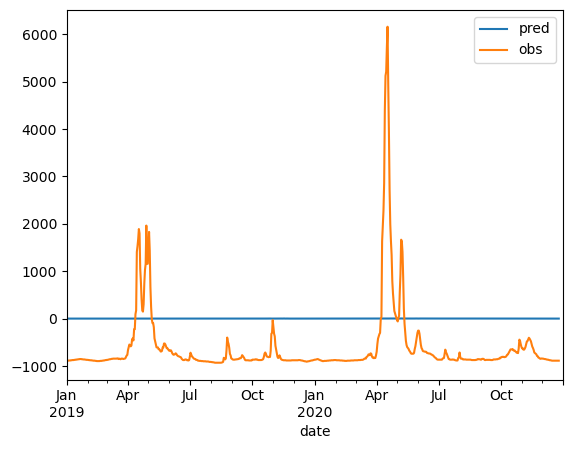

In [27]:

res_df.loc[:'2020-12-31', ['pred', 'obs']].plot();

In [27]:
select_rule = (obs_df.gauge_id == gauge_id) & \
    (obs_df.time_idx.isin(idx['time_idx']))  # type: ignore

idx.loc[:, 'date'] = obs_df['date'][select_rule].values  # type: ignore


# assemble rescaling procedure
compare_res = obs_df[obs_df['gauge_id'] == gauge_id]
compare_res = compare_res[[val in idx['time_idx'].values  # type: ignore
                            for val in compare_res['time_idx'].values]]
compare_res[f'{hydro_target}_pred'] = res

if with_static:
    with_pred = compare_res[[f'{hydro_target}_pred',
                            *meteo_input, *static_parameters]]
    with_obs = compare_res[[hydro_target,
                            *meteo_input, *static_parameters]]

    new_scaler = MinMaxScaler()

    new_scaler.min_, new_scaler.scale_ = scaler.min_, scaler.scale_

    # recalculate
    with_pred[[f'{hydro_target}_pred',
                *meteo_input,
                *static_parameters]] = new_scaler.inverse_transform(with_pred)
    with_obs[[hydro_target,
                *meteo_input,
                *static_parameters]] = scaler.inverse_transform(with_obs)
else:
    with_pred = compare_res[[f'{hydro_target}_pred', *meteo_input]]
    with_obs = compare_res[[hydro_target, *meteo_input]]

    new_scaler = MinMaxScaler()

    new_scaler.min_, new_scaler.scale_ = scaler.min_, scaler.scale_

    # recalculate
    with_pred[[f'{hydro_target}_pred',
                *meteo_input]] = new_scaler.inverse_transform(with_pred)
    with_obs[[hydro_target,
                *meteo_input]] = scaler.inverse_transform(with_obs)
compare_res = compare_res[['date', f'{hydro_target}',
                               f'{hydro_target}_pred']]
compare_res[f'{hydro_target}'] = with_obs[hydro_target]
compare_res[f'{hydro_target}_pred'] = with_pred[f'{hydro_target}_pred']
compare_res = compare_res.set_index('date')

ValueError: Must have equal len keys and value when setting with an iterable

In [14]:
compare_res

,q_mm_day,q_mm_day_pred
date,,
2008-12-31,-817.199273,702.982258
2009-01-01,-821.511117,742.388558
2009-01-02,-830.134805,745.105232
2009-01-03,-834.446649,703.355224
2009-01-04,-838.758494,699.063145
...,...,...
2019-12-21,-903.436156,654.751527
2019-12-22,-899.124312,556.225663
2019-12-23,-899.124312,621.750500


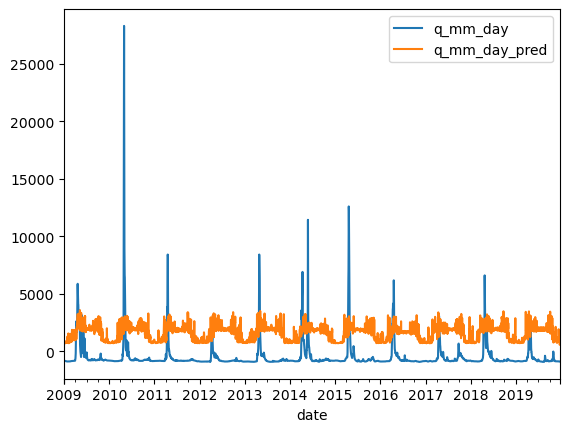

In [15]:
compare_res[['q_mm_day', 'q_mm_day_pred']].plot();

In [52]:
test_file = model_file.iloc[:5000, :]

In [61]:
xr.open_dataset('../geo_data/great_db/nc_concat/3237.nc').to_dataframe().droplevel(1)[['prcp_e5l']].groupby(pd.Grouper(freq='1Y')).sum()

,prcp_e5l
date,
2008-12-31,555.691203
2009-12-31,602.182686
2010-12-31,527.733530
2011-12-31,598.536311
2012-12-31,604.995711
2013-12-31,651.708987
2014-12-31,580.225835
2015-12-31,460.180942
2016-12-31,651.806015


In [15]:
unified_df = xr.open_mfdataset(glob.glob(
    '../geo_data/nc_concat_cmip_2017-2030/*.nc'))

In [4]:
cmip_gauge = xr.open_dataset(
        f'../geo_data/nc_concat_cmip_2017-2030/10002.nc')
cmip_gauge

<xarray.Dataset>
Dimensions:                                                      (date: 9590,
                                                                  gauge_id: 1)
Coordinates:
  * date                                                         (date) datetime64[ns] ...
  * gauge_id                                                     (gauge_id) object ...
Data variables: (12/48)
    daily_maximum_near_surface_air_temperature_access_cm2        (date) float64 ...
    daily_minimum_near_surface_air_temperature_access_cm2        (date) float64 ...
    precipitation_access_cm2                                     (date) float64 ...
    daily_maximum_near_surface_air_temperature_awi_cm_1_1_mr     (date) float64 ...
    daily_minimum_near_surface_air_temperature_awi_cm_1_1_mr     (date) float64 ...
    precipitation_awi_cm_1_1_mr                                  (date) float64 ...
    ...                                                           ...
    daily_maximum_near_surface_air_temperature_noresm2_mm        (date) float64 ...
    daily_minimum_near_surface_air_temperature_noresm2_mm        (date) float64 ...
    precipitation_noresm2_mm                                     (date) float64 ...
    daily_maximum_near_surface_air_temperature_ukesm1_0_ll       (date) float64 ...
    daily_minimum_near_surface_air_temperature_ukesm1_0_ll       (date) float64 ...
    precipitation_ukesm1_0_ll                                    (date) float64 ...

In [8]:
mrm_ggs = gpd.read_file('../geo_data/great_db/geometry/murmansk_gauges.gpkg')
mrm_ggs = mrm_ggs.set_index('gauge_id', drop=True)
ws_file = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')
ws_file = ws_file.set_index('gauge_id')


In [14]:
static_attrs = pd.read_csv('../geo_data/attributes/geo_vector.csv')
static_attrs['gauge_id'] = static_attrs['gauge_id'].astype(str)
static_attrs = static_attrs.set_index('gauge_id')


In [17]:
mrm_ws = ws_file.loc[ws_file.index.isin(mrm_ggs.index)]
mrm_ws.to_file('../geo_data/MURMANSK_RES/geometry/murmansk_ws.gpkg')
mrm_ggs.to_file('../geo_data/MURMANSK_RES/geometry/murmansk_gauges.gpkg')
mrm_static = static_attrs.loc[static_attrs.index.isin(mrm_ggs.index)]
mrm_static.to_csv('../geo_data/MURMANSK_RES/geometry/murmansk_static.csv')


In [20]:
q_obs = {'full': list(),
         'partial': list(),
         'empty': list()}
h_obs = {'full': list(),
         'partial': list(),
         'empty': list()}


def nan_fractor(df_col: pd.Series):
    nan_frac = df_col.isna().sum() / len(df_col)
    return nan_frac


nc_cond = [file.split('/')[-1][:-3] for file
           in glob.glob('../geo_data/great_db/nc_concat/*.nc')]

for file in glob.glob('../geo_data/great_db/ais_data/q_h/*.csv'):
    gauge_id = file.split('/')[-1][:-4]
    if gauge_id in nc_cond:
        test = pd.read_csv(file, index_col='date')
        lvls = test[['lvl_sm', 'lvl_mbs']]
        dschrg = test[['q_cms_s', 'q_mm_day']]

        fraction_of_nan_q = dschrg['q_cms_s'].isna().sum() / len(dschrg)

        if fraction_of_nan_q == 0.0:
            q_obs['full'].append(gauge_id)
        elif fraction_of_nan_q <= 0.25:
            q_obs['partial'].append(gauge_id)
        elif fraction_of_nan_q > 0.25:
            q_obs['empty'].append(gauge_id)

        fraction_of_nan_h = lvls['lvl_mbs'].isna().sum() / len(lvls)

        if fraction_of_nan_h == 0.0:
            h_obs['full'].append(gauge_id)
        elif fraction_of_nan_h <= 0.25:
            h_obs['partial'].append(gauge_id)
        elif fraction_of_nan_h > 0.25:
            h_obs['empty'].append(gauge_id)
    else:
        continue


for fill_type, idx in q_obs.items():
    g_list = [g for g in mrm_ggs.index if g in q_obs[fill_type]]
    s_path = Path(f'../geo_data/MURMANSK_RES/discharge/{fill_type}')
    s_path.mkdir(exist_ok=True, parents=True)
    
    for f in [f for f in glob.glob('../geo_data/great_db/nc_concat/*.nc')
              if f.split('/')[-1][:-3] in g_list]:
        fl = xr.open_dataset(f)
        f_name = f.split('/')[-1][:-3]
        fl.to_netcdf(f'{s_path}/{f_name}.nc')


for fill_type, idx in h_obs.items():
    g_list = [g for g in mrm_ggs.index if g in h_obs[fill_type]]
    s_path = Path(f'../geo_data/MURMANSK_RES/levels/{fill_type}')
    s_path.mkdir(exist_ok=True, parents=True)

    for f in [f for f in glob.glob('../geo_data/great_db/nc_concat/*.nc')
              if f.split('/')[-1][:-3] in g_list]:
        fl = xr.open_dataset(f)
        f_name = f.split('/')[-1][:-3]
        fl.to_netcdf(f'{s_path}/{f_name}.nc')


In [2]:
import shutil
from scripts.tft_data import open_for_tft

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import pytorch_lightning as pl
from scripts.tft_data import open_for_tft, train_val_split
from scripts.model_eval import nnse, pred_res_builder
import torch
torch.set_float32_matmul_precision('medium')
from warnings import simplefilter
import pandas as pd
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


import glob
import geopandas as gpd

/opt/conda/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
static_attributes = pd.read_csv('../geo_data/attributes/geo_vector.csv',
                                        index_col='gauge_id')

In [4]:
meteo_input = ['prcp_e5l',  't_max_e5l', 't_min_e5l']
hydro_target = 'q_mm_day'

ws_file = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')
ws_file = ws_file.set_index('gauge_id')
# ws_file = ws_file[ws_file['new_area'] <= 50000]




In [12]:
file = open_for_tft(
    nc_files=glob.glob('../geo_data/great_db/nc_all_q/*.nc')[:3],
    static_path='../geo_data/attributes/geo_vector.csv',
    area_index=ws_file.index,
    with_static=True,
    shuffle_static=False)
file

,date,gauge_id,lvl_sm,q_cms_s,lvl_mbs,q_mm_day,t_max_e5l,t_max_e5,t_min_e5l,t_min_e5,...,snd_pc_sav,kar_pc_sse,urb_pc_sse,gwt_cm_sav,lkv_mc_usu,rev_mc_usu,sgr_dk_sav,slp_dg_sav,ws_area,ele_mt_sav
0,2008-01-01,10620,98.0,0.29,131.58,0.125257,-11.167394,-11.151410,-12.552533,-12.539866,...,36.333333,0.000000,0.000000,18.777778,2.333333,0.0,24.555556,0.922222,199.518281,171.888889
1,2008-01-02,10620,99.0,0.30,131.59,0.129576,-10.947719,-10.944166,-13.725148,-13.739626,...,36.333333,0.000000,0.000000,18.777778,2.333333,0.0,24.555556,0.922222,199.518281,171.888889
2,2008-01-03,10620,99.0,0.30,131.59,0.129576,-14.765779,-14.782820,-37.482260,-37.454216,...,36.333333,0.000000,0.000000,18.777778,2.333333,0.0,24.555556,0.922222,199.518281,171.888889
3,2008-01-04,10620,99.0,0.30,131.59,0.129576,-28.399687,-28.433760,-39.172446,-39.178672,...,36.333333,0.000000,0.000000,18.777778,2.333333,0.0,24.555556,0.922222,199.518281,171.888889
4,2008-01-05,10620,99.0,0.30,131.59,0.129576,-19.875124,-19.837551,-27.239561,-27.281795,...,36.333333,0.000000,0.000000,18.777778,2.333333,0.0,24.555556,0.922222,199.518281,171.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14242,2020-12-27,8306,211.0,42.80,360.53,0.214904,-28.932631,-28.881615,-34.421851,-34.382707,...,53.442105,27.068421,0.084211,303.389474,13.357895,0.0,193.257895,11.485263,17171.167521,1209.557895
14243,2020-12-28,8306,210.0,42.10,360.52,0.211390,-29.710255,-29.628865,-35.999785,-35.959329,...,53.442105,27.068421,0.084211,303.389474,13.357895,0.0,193.257895,11.485263,17171.167521,1209.557895
14244,2020-12-29,8306,213.0,41.40,360.55,0.207875,-26.838288,-26.797496,-35.279664,-35.242800,...,53.442105,27.068421,0.084211,303.389474,13.357895,0.0,193.257895,11.485263,17171.167521,1209.557895
14245,2020-12-30,8306,210.0,40.60,360.52,0.203858,-23.855378,-23.806737,-31.402677,-31.407086,...,53.442105,27.068421,0.084211,303.389474,13.357895,0.0,193.257895,11.485263,17171.167521,1209.557895


In [8]:
(train_ds, train_loader,
 val_ds, val_loader, val_df,
 scaler) = train_val_split(file, with_static=True,
                           shuffle_static=True)

NameError: name 'static_attributes' is not defined

In [7]:
val_df


,date,time_idx,gauge_id,q_mm_day,prcp_e5l,t_max_e5l,t_min_e5l,for_pc_sse,crp_pc_sse,inu_pc_ult,...,snd_pc_sav,kar_pc_sse,urb_pc_sse,gwt_cm_sav,lkv_mc_usu,rev_mc_usu,sgr_dk_sav,slp_dg_sav,ws_area,ele_mt_sav
0,2018-01-01,0,10620,1.034539,1.011639,3.270626,3.694076,3.009268,10.00000,1.000000,...,1.000000,1.0,1.0,1.194232,1.000000,1.0,1.361292,1.0,1.097044,2.122678
1,2018-01-02,1,10620,1.031882,1.001630,3.250335,3.313270,3.009268,10.00000,1.000000,...,1.000000,1.0,1.0,1.194232,1.000000,1.0,1.361292,1.0,1.097044,2.122678
2,2018-01-03,2,10620,1.029225,1.000106,3.186169,3.259177,3.009268,10.00000,1.000000,...,1.000000,1.0,1.0,1.194232,1.000000,1.0,1.361292,1.0,1.097044,2.122678
3,2018-01-04,3,10620,1.027897,1.000090,3.677870,3.293262,3.009268,10.00000,1.000000,...,1.000000,1.0,1.0,1.194232,1.000000,1.0,1.361292,1.0,1.097044,2.122678
4,2018-01-05,4,10620,1.025240,1.000161,3.436083,3.250773,3.009268,10.00000,1.000000,...,1.000000,1.0,1.0,1.194232,1.000000,1.0,1.361292,1.0,1.097044,2.122678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,2020-12-27,1091,8306,1.046170,1.037985,2.190298,2.348895,10.000000,1.09909,1.046213,...,7.118369,10.0,10.0,10.000000,6.045138,1.0,10.000000,10.0,10.000000,10.000000
3284,2020-12-28,1092,8306,1.045089,1.004357,2.094081,2.134823,10.000000,1.09909,1.046213,...,7.118369,10.0,10.0,10.000000,6.045138,1.0,10.000000,10.0,10.000000,10.000000
3285,2020-12-29,1093,8306,1.044008,1.000523,2.449435,2.232519,10.000000,1.09909,1.046213,...,7.118369,10.0,10.0,10.000000,6.045138,1.0,10.000000,10.0,10.000000,10.000000
3286,2020-12-30,1094,8306,1.042772,1.000400,2.818515,2.758493,10.000000,1.09909,1.046213,...,7.118369,10.0,10.0,10.000000,6.045138,1.0,10.000000,10.0,10.000000,10.000000


In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')


meteo_input = ['prcp_e5l',  't_max_e5l', 't_min_e5l']
hydro_target = 'q_mm_day'
static_parameters = ['for_pc_sse', 'crp_pc_sse',
                     'inu_pc_ult', 'ire_pc_sse',
                     'lka_pc_use', 'prm_pc_sse',
                     'pst_pc_sse', 'cly_pc_sav',
                     'slt_pc_sav', 'snd_pc_sav',
                     'kar_pc_sse', 'urb_pc_sse',
                     'gwt_cm_sav', 'lkv_mc_usu',
                     'rev_mc_usu', 'sgr_dk_sav',
                     'slp_dg_sav', 'ws_area',
                     'ele_mt_sav']


ws_file = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')
ws_file = ws_file.set_index('gauge_id')
ws_file = ws_file[ws_file['new_area'] <= 50000]

Using device: cuda

NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [19]:
from tqdm.notebook import tqdm
by_gauge_res = list()
by_gauge_static = list()
by_gauge_attention = list()
for nc_file in tqdm(glob.glob('../geo_data/great_db/nc_all_q/*.nc')):
    gauge_id = nc_file.split('/')[-1][:-3]
    try:
        file = open_for_tft(
            nc_files=[nc_file],
            static_path='../geo_data/attributes/geo_vector.csv',
            area_index=ws_file.index,
            meteo_predictors=meteo_input,
            hydro_target=hydro_target, allow_nan=True)

        (_, _,
         val_ds, _, val_df,
         scaler) = train_val_split(file)

        chkpt = glob.glob(
            f'./single_gauge_8epoch/{gauge_id}_tft/*/*/checkpoints/*.ckpt')[0]
        resdf, _, static, attention_vals = pred_res_builder(
            gauge_id=gauge_id,
            hydro_target=hydro_target,
            meteo_input=meteo_input,
            static_parameters=static_parameters,
            model_checkpoint=chkpt,
            res_storage='./result/tft_single_8epoch',
            val_df=val_df,
            scaler=scaler,
            val_ts_ds=val_ds, with_plot=False)
        by_gauge_res.append(resdf)
        by_gauge_static.append(static)
        by_gauge_attention.append(attention_vals)
    except Exception:
        continue

by_gauge_static = pd.concat(by_gauge_static)
by_gauge_static.to_csv('./result/tft_by_gauge_static.csv')

by_gauge_attnt = pd.concat(by_gauge_attention)
by_gauge_attnt.to_csv('./result/tft_by_gauge_attention.csv')

by_gauge_res = pd.concat(by_gauge_res)
by_gauge_res.to_csv('./result/tft_by_gauge_EVERYTHING.csv', index=False)


A Jupyter Widget

/opt/conda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/workspac